In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Import data

In [2]:
cars = pd.read_csv('cars.csv')
cars.tail()

,Unnamed: 0,name,gearbox,fuel,mfd_date,mileage,power,price
1180,1180,"Volkswagen Passat, 1.8 l., universalas",Mechaninė,Benzinas,1998-08,270000,85,850
1181,1181,"Volkswagen Passat, universalas",Mechaninė,Dyzelinas,2005,236000,103,4800
1182,1182,"Volkswagen Passat, 2.0 l., universalas",Automatinė,Dyzelinas,2013-06,193000,130,10500
1183,1183,"Volkswagen Passat, 1.8 l., sedanas",Automatinė,Benzinas,2016-09,24000,125,14900
1184,1184,"Volkswagen Passat, 1.8 l., sedanas",Automatinė,Benzinas,2015,100000,125,7999


Clean and reshape data

In [3]:
cars = cars[cars['mileage'] <= 500000]
cars = cars[((cars['mileage'] < 10000) & (cars['price'] > 5000)) | (cars['mileage'] > 10000)]

cars['year'] = cars['mfd_date'].apply(lambda x: int(x[:4]))

cars = cars.drop(['Unnamed: 0', 'name', 'fuel', 'mfd_date'], axis=1)
cars.tail()

,gearbox,mileage,power,price,year
1180,Mechaninė,270000,85,850,1998
1181,Mechaninė,236000,103,4800,2005
1182,Automatinė,193000,130,10500,2013
1183,Automatinė,24000,125,14900,2016
1184,Automatinė,100000,125,7999,2015


Convert categorical data to numbers

In [4]:
cars = pd.get_dummies(cars)
cars.tail()

,mileage,power,price,year,gearbox_Automatinė,gearbox_Mechaninė
1180,270000,85,850,1998,0,1
1181,236000,103,4800,2005,0,1
1182,193000,130,10500,2013,1,0
1183,24000,125,14900,2016,1,0
1184,100000,125,7999,2015,1,0


Split data into training and testing datasets

In [5]:
train_dataset = cars.sample(frac=0.8,random_state=1)
test_dataset = cars.drop(train_dataset.index)

Get training data stats

In [6]:
train_stats = train_dataset.describe()
train_stats.pop('price')
train_stats = train_stats.transpose()

Pop training and testing labels

In [7]:
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

Normalize data

In [8]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Build and compile model

In [9]:
model = keras.Sequential([
  layers.Dense(80, activation='relu', input_shape=[len(train_dataset.keys())]),
  layers.Dense(40, activation='relu'),
  layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(0.001)

model.compile(loss='mae',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

Create early stop callback

In [10]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Train model

In [11]:
model.fit(normed_train_data, train_labels, 
                    epochs=300, validation_split = 0.2, verbose=2, 
                    callbacks=[early_stop])

Epoch 1/300
24/24 - 0s - loss: 7146.8257 - mae: 7146.8257 - mse: 86932320.0000 - val_loss: 6830.8003 - val_mae: 6830.8003 - val_mse: 83036448.0000
Epoch 2/300
24/24 - 0s - loss: 7146.7378 - mae: 7146.7378 - mse: 86931040.0000 - val_loss: 6830.7124 - val_mae: 6830.7124 - val_mse: 83035192.0000
Epoch 3/300
24/24 - 0s - loss: 7146.6475 - mae: 7146.6475 - mse: 86929696.0000 - val_loss: 6830.6211 - val_mae: 6830.6211 - val_mse: 83033880.0000
Epoch 4/300
24/24 - 0s - loss: 7146.5527 - mae: 7146.5527 - mse: 86928264.0000 - val_loss: 6830.5239 - val_mae: 6830.5239 - val_mse: 83032488.0000
Epoch 5/300
24/24 - 0s - loss: 7146.4536 - mae: 7146.4536 - mse: 86926808.0000 - val_loss: 6830.4224 - val_mae: 6830.4224 - val_mse: 83031048.0000
Epoch 6/300
24/24 - 0s - loss: 7146.3477 - mae: 7146.3477 - mse: 86925232.0000 - val_loss: 6830.3164 - val_mae: 6830.3164 - val_mse: 83029520.0000
Epoch 7/300
24/24 - 0s - loss: 7146.2358 - mae: 7146.2358 - mse: 86923584.0000 - val_loss: 6830.2041 - val_mae: 6830.2

Evaluate model

In [12]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Loss: {:5.2f}".format(loss))

8/8 - 0s - loss: 1131.6140 - mae: 1131.6140 - mse: 4129294.5000
Testing set Loss: 1131.61


Plot predictions versus true labels

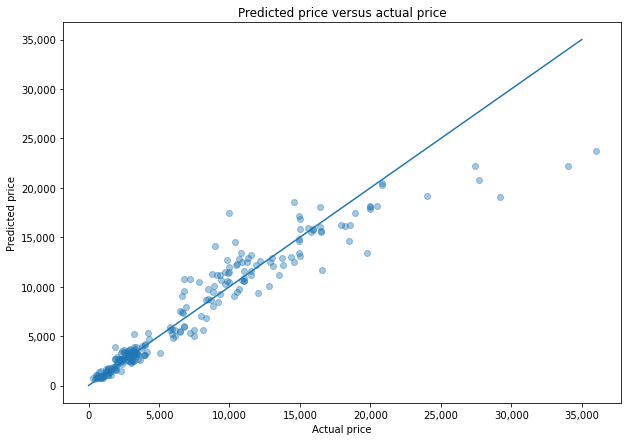

In [13]:
test_predictions = model.predict(normed_test_data).flatten()

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(test_labels, test_predictions, alpha=0.4)
ax.set_title('Predicted price versus actual price')
ax.set_xlabel('Actual price')
ax.set_ylabel('Predicted price')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.plot(range(35000), range(35000))
plt.show()

In [14]:
new_data = pd.DataFrame({'mileage': [230000], 'power': [125], 'year': [2012], 'gearbox_Automatinė': [1], 'gearbox_Mechaninė': [0]})
normed_new_data = norm(new_data)

In [15]:
new_predictions = model.predict(normed_new_data).flatten()
new_predictions

array([7574.524], dtype=float32)